# ECOSTRESS data wrangling

From [AppEEARS](https://lpdaacsvc.cr.usgs.gov/appeears), I've downloaded a whole collection of geotiffs for ECOSTRESS LST for a bounding box around Grand Mesa.


In [1]:
import os
import xarray as xr
import rioxarray as rioxr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, mapping

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Open shapefiles

In [3]:
# point shapefiles
mesa_west = gpd.read_file('zip://../data/shapefiles/MW.zip')
snow_pit = gpd.read_file('zip://../data/shapefiles/2s10.zip')

# add buffers
r = 0.001 # units?
mesa_west_buffer = mesa_west.buffer(r)
snow_pit_buffer = snow_pit.buffer(r)

Set the path to the top level directory where all our ECOSTRESS images are, their file extension, and product name.

In [4]:
eco_tiff_path = r'C:\Users\steve\Desktop\GrandMesa_ECOSTRESS'
ext = '.tif'
product = 'SDS_LST_doy'

Get a list of all our ECOSTRESS LST files

In [5]:
# get list of all tif files
file_list = []
for root, dirs, files in os.walk(eco_tiff_path):
    for file in files:
        if file.endswith(ext):
            if product in file:
                 file_list.append( os.path.join(root, file) ) 

In [6]:
file_list

['C:\\Users\\steve\\Desktop\\GrandMesa_ECOSTRESS\\ECO2LSTE.001_SDS_LST_doy2020035025939_aid0001.tif',
 'C:\\Users\\steve\\Desktop\\GrandMesa_ECOSTRESS\\ECO2LSTE.001_SDS_LST_doy2020038021340_aid0001.tif',
 'C:\\Users\\steve\\Desktop\\GrandMesa_ECOSTRESS\\ECO2LSTE.001_SDS_LST_doy2020039012604_aid0001.tif',
 'C:\\Users\\steve\\Desktop\\GrandMesa_ECOSTRESS\\ECO2LSTE.001_SDS_LST_doy2020042172135_aid0001.tif',
 'C:\\Users\\steve\\Desktop\\GrandMesa_ECOSTRESS\\ECO2LSTE.001_SDS_LST_doy2020042172227_aid0001.tif',
 'C:\\Users\\steve\\Desktop\\GrandMesa_ECOSTRESS\\ECO2LSTE.001_SDS_LST_doy2020042235230_aid0001.tif',
 'C:\\Users\\steve\\Desktop\\GrandMesa_ECOSTRESS\\ECO2LSTE.001_SDS_LST_doy2020045230625_aid0001.tif',
 'C:\\Users\\steve\\Desktop\\GrandMesa_ECOSTRESS\\ECO2LSTE.001_SDS_LST_doy2020046154808_aid0001.tif',
 'C:\\Users\\steve\\Desktop\\GrandMesa_ECOSTRESS\\ECO2LSTE.001_SDS_LST_doy2020046154900_aid0001.tif',
 'C:\\Users\\steve\\Desktop\\GrandMesa_ECOSTRESS\\ECO2LSTE.001_SDS_LST_doy20200462

Mean: -17.9
Max: -16.6
Min: -18.4
Std: 0.6
Mean: -18.4
Max: -16.8
Min: -21.1
Std: 1.2


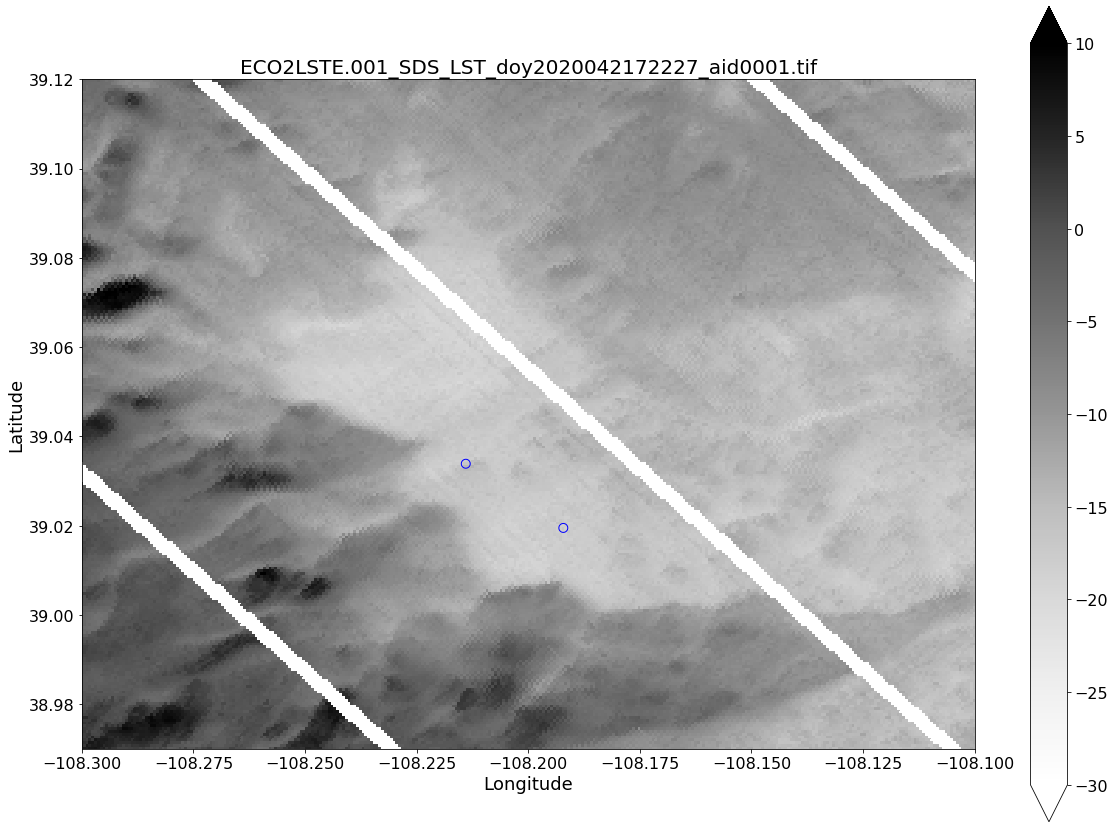

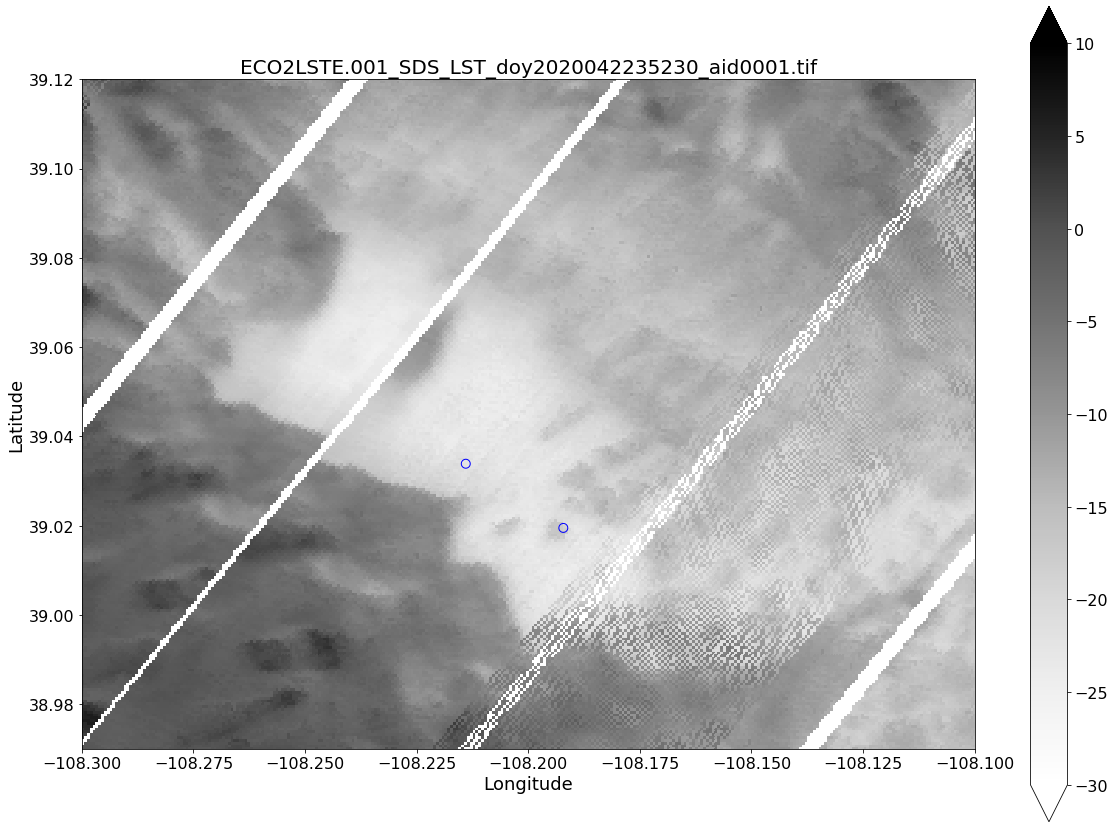

In [8]:
for file in file_list[4:6]:

    
    eco_lst = xr.open_rasterio(file)
    eco_lst = eco_lst[0]

    # make sure we're in the same CRS
    
    
    mesa_west_buffer = mesa_west_buffer.to_crs(eco_lst.crs)
    snow_pit_buffer = snow_pit_buffer.to_crs(eco_lst.crs)
    
    #print('ECOSTRESS CRS: {}'.format(eco_lst.crs))
    #print('Shapefile CRS: {}'.format(mesa_west_buffer.crs))
    #print('Shapefile CRS: {}'.format(snow_pit_buffer.crs))
    
    
    # Scale the temperature values and convert from K to C
    scaled_eco_lst = eco_lst * float(eco_lst.attrs['scale_factor']) - 273.15
    
    #Plot our ECOSTRESS image and two buffered points
    
    fig, ax = plt.subplots(figsize=(20,15))
    
    scaled_eco_lst.plot(x='x', y='y', ax=ax, vmin=-30, vmax=10, cmap='Greys')
    
    mesa_west_buffer.plot(ax=ax, edgecolor='blue', facecolor='none');
    snow_pit_buffer.plot(ax=ax, edgecolor='blue', facecolor='none');
    
    ax.set_xlim((-108.3, -108.1))
    ax.set_ylim((38.97, 39.12))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(file.split('\\')[-1])
    
    ax.set_aspect(1)
    #plt.savefig('{}.jpg'.format(file.split('\\')[-1]),dpi=300)
    
    
    
    # Get zonal stats
    
    
    for shapefile in [snow_pit_buffer]:#, mesa_west_buffer]:
    
        shapefile_lst = eco_lst.rio.clip(shapefile.geometry.apply(mapping), crs=eco_lst.crs)
    
        # switch our zero values to nan values
        shapefile_lst = shapefile_lst.where(shapefile_lst > 0)
    
        # scale our clipped dataset and convert from K to C
        scaled_shapefile_lst = ( shapefile_lst * float(eco_lst.attrs['scale_factor']) ) - 273.15
    
    
        # Compute zonal statistics
        # Remove NaN pixel values
        values = scaled_shapefile_lst.values.flatten()
        values = values[~np.isnan(values)]
    
        lst_mean = values.mean()
        lst_max = values.max()
        lst_min = values.min()
        lst_std = values.std()
    
        # Print zonal statistics
        summary_stats = 'Mean: {}\nMax: {}\nMin: {}\nStd: {}'.format(np.round(lst_mean,1),
                                                                     np.round(lst_max,1),
                                                                     np.round(lst_min,1),
                                                                     np.round(lst_std,1))
    
        print(summary_stats)